In [1]:
#!pip install wordcloud
#!pip install hvplot

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from dask import bag
from dask import diagnostics

import hvplot.pandas

import util

In [3]:
train_img_dir='../../data/train_images'
test_img_dir='../../data/test_images'
train_csv_path = '../../data/train.csv'
test_csv_path = '../../data/test.csv'

In [4]:
train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

In [5]:
pd.set_option('display.width',1000)
pd.set_option('max_columns',5)
train.head(10)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
5,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2660605217
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
7,train_1806152124,0014f61389cbaa687a58e38a97b6383d.jpg,eea7e1c0c04da33d,KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...,1565741687
8,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2359912463
9,train_831680791,001be52b2beec40ddc1d2d7fc7a68f08.jpg,e1ce953d1a70618f,BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KAN...,2630990665


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   3 non-null      object
 1   image        3 non-null      object
 2   image_phash  3 non-null      object
 3   title        3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


In [8]:
print('Check for number of unique values for each feature')
for col in train.columns:
    print(col+':'+str(len(train[col].unique())))

Check for number of unique values for each feature
posting_id:34250
image:32412
image_phash:28735
title:33117
label_group:11014


In [9]:
label_count = train.label_group.value_counts()

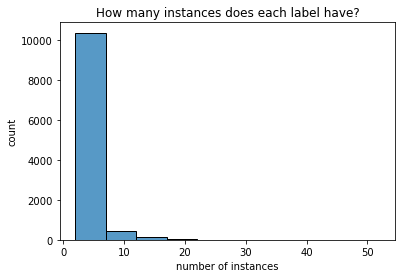

In [10]:
ax = sns.histplot(label_count.tolist(),stat='count',binwidth=5)
ax.set(title='How many instances does each label have?',xlabel='number of instances', ylabel='count')
plt.show()

In [11]:
label_count[:20]

3627744656    51
1163569239    51
994676122     51
3113678103    51
1141798720    51
159351600     51
562358068     51
3206118280    49
1733221456    46
1166650192    46
1091404026    45
3489985175    41
1237550763    37
1746655739    36
2008989859    35
452508504     35
4184214313    35
731330024     35
66247839      34
1575763518    34
Name: label_group, dtype: int64

**General EDA summary**:
- No NA's
- Incredibly small test set: will probably rely more on validation set
- Most images have 5 images or fewer. However, top 20 labels all have 30+ images
- 32412 unique images in the dataset, 34250 records in the dataset - investigate whether they are duplicates

#### EDA: Title

In [12]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=400,height=400,background_color='white').generate(text)
    plt.figure(figsize = (8, 8)) 
    plt.imshow(wordcloud)
    plt.axis('off')

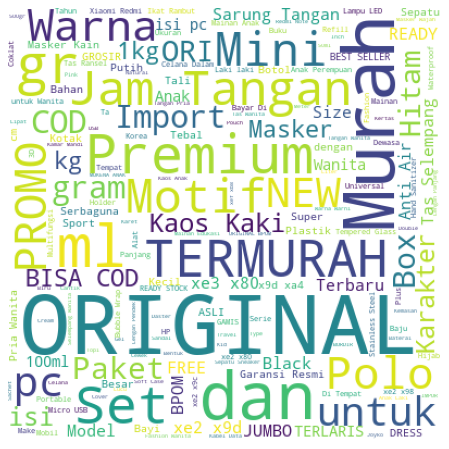

In [13]:
plot_wordcloud(' '.join(train['title']))

In [14]:
text_clean = train.title.apply(lambda text: util.text_preprocessing(text))

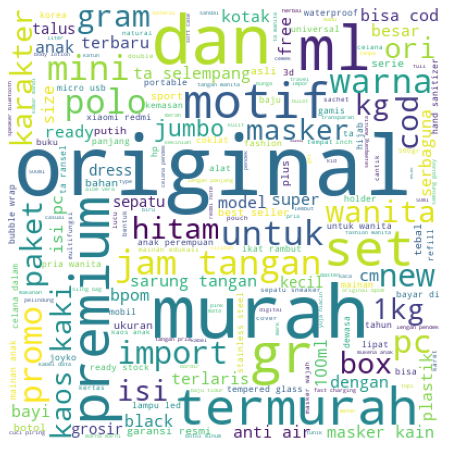

In [15]:
plot_wordcloud(' '.join(text_clean))

We now explore if text can be useful for the project as one of the ensembled methods.

In [16]:
embedder = SentenceTransformer('bert-large-nli-mean-tokens')
def embed_title(title):
    title_embedding = embedder.encode(title)
    return title_embedding

In [17]:
start = datetime.now()
title_embedded = [embed_title(text) for text in text_clean]
print(datetime.now()-start)
train['title_embed'] = title_embedded

0:17:23.416650


In [18]:
arr_embed = np.stack(train['title_embed'])
similarity_matrix = cosine_similarity(arr_embed)

In [19]:
print(f'The overall similarity among items is: {similarity_matrix.mean()}')

The overall similarity among items is: 0.45751070976257324


In [20]:
labels = train.label_group.unique()
similarities = []
for l in labels:
    group_label = train[train.label_group==l]
    arr_embed = np.stack(group_label['title_embed'])
    similarity = cosine_similarity(arr_embed).mean()
    similarities.append(similarity)

In [21]:
print(f'The overall similarity among items is: {np.mean(similarities)}')

The overall similarity among items is: 0.8731818199157715


**Title EDA summary**:
- Title similarity is vastly better among items of the same label. This shows that title can be a great predictor for our purpose

#### EDA: Images

In [22]:
train_img_path=util.get_all_img_path(train_img_dir)
test_img_path=util.get_all_img_path(test_img_dir)

In [23]:
sample_img = cv2.imread(train_img_path[0])

In [24]:
print(f'The shape of the image is: {sample_img.shape}')

The shape of the image is: (1024, 1024, 3)


In [25]:
np.min(sample_img), np.max(sample_img)

(0, 255)

In [26]:
img_dim_bag = bag.from_sequence(train_img_path).map(lambda path: cv2.imread(path).shape)
with diagnostics.ProgressBar():
    dims = img_dim_bag.compute()

[########################################] | 100% Completed | 41.2s


In [27]:
df_dims = pd.DataFrame(dims,columns=['height','width','color'])

In [28]:
df_dims.color.unique()

array([3], dtype=int64)

In [29]:
dim_count = df_dims.groupby(['height','width']).size().reset_index().rename(columns={0:'count'})

In [30]:
dim_count.sort_values('count',ascending=False)

,height,width,count
441,640,640,12034
804,1024,1024,6034
601,800,800,3683
501,700,700,2537
782,1000,1000,1464
...,...,...,...
376,613,476,1
375,612,640,1
370,608,640,1
363,601,605,1


In [31]:
dim_count.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1400), ylim=(0,1400), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0.3)

:Scatter   [height]   (width,count)

**Image EDA summary**:
- Images are of varying sizes, with 640 x 640 and 1024 x 1024 being the most popular dimensions.
- Most images are square, but some have different height and width.
- Some images have a much bigger resolution, considered as outliers: 1400 x 1400
- Every image is RGB, 0-255 colored.

## References
Exploratory Data Analysis: https://www.kaggle.com/ishandutta/v7-shopee-indepth-eda-one-stop-for-all-your-needs